In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [14]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
print(stoi)
itos = {i: char for char, i in stoi.items()}
print(itos)


{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [29]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    context = ['.']*3 + [char for char in word] + ['.']
    # print(context)
    for i in range(3, len(context)):
        # print(context[i-3:i], "-->", context[i])
        xtoi = [stoi[char] for char in context[i-3:i]]
        ytoi = stoi[context[i]]
        X.append(xtoi)
        Y.append(ytoi)

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype
# (torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [33]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for word in words:
        context = ['.']*3 + [char for char in word] + ['.']
        # print(context)
        for i in range(3, len(context)):
            # print(context[i-3:i], "-->", context[i])
            xtoi = [stoi[char] for char in context[i-3:i]]
            ytoi = stoi[context[i]]
            X.append(xtoi)
            Y.append(ytoi)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words) # train/val.test slip method: shuffle first, then slide by cutoff numbers
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# torch.Size([182441, 3]) torch.Size([182441])
# torch.Size([22902, 3]) torch.Size([22902])
# torch.Size([22803, 3]) torch.Size([22803])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [34]:
print(Xte) # each line is an example, next to embed each char into 2-dim embedding space
print(Yte)

tensor([[ 0,  0,  0],
        [ 0,  0, 11],
        [ 0, 11, 18],
        ...,
        [ 0, 10,  5],
        [10,  5,  1],
        [ 5,  1, 14]])
tensor([11, 18,  9,  ...,  1, 14,  0])


In [36]:
# look up table for each char is shape of  [27, 2]  Bengio et al. 2003 MLP language model paper 
C = torch.randn([27, 2])
print(C)

tensor([[-1.6932,  0.1615],
        [ 1.2923,  0.7740],
        [ 0.8269,  0.9148],
        [ 1.3213,  1.8640],
        [ 0.2952,  1.1093],
        [-0.1047,  0.3893],
        [ 1.3242,  2.9137],
        [-1.3035, -0.1078],
        [ 1.5817, -0.4753],
        [-1.2669, -1.0368],
        [-0.9358,  1.6605],
        [-0.7248,  1.0975],
        [ 1.7111,  0.1533],
        [ 0.4768, -1.8398],
        [-0.3417,  0.2264],
        [-0.2508, -0.6795],
        [ 1.7060,  1.2543],
        [ 0.5621, -1.1622],
        [ 0.7437,  0.5686],
        [ 0.4131, -0.1856],
        [-0.0715,  1.6329],
        [-0.6543, -1.4739],
        [-0.0216, -0.3874],
        [ 1.3335,  1.5009],
        [-1.2614, -0.9850],
        [-0.5595, -0.5653],
        [ 0.5256,  1.1212]])


In [37]:
C[5]

tensor([-0.1047,  0.3893])

In [42]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C   #matrix multiplication

tensor([-0.1047,  0.3893])

In [43]:
C[torch.tensor([5,6,7,7,7])] # index C with a vector (contains multiple position)

tensor([[-0.1047,  0.3893],
        [ 1.3242,  2.9137],
        [-1.3035, -0.1078],
        [-1.3035, -0.1078],
        [-1.3035, -0.1078]])

In [49]:
C[torch.tensor([[5,6,7,],[7,7,7]])]  
# index C with  tensor of shape of (2,3), return [2,3,2] where [2,3,] -> index tensor shape, [,,2] -> C 2-dim


tensor([[[-0.1047,  0.3893],
         [ 1.3242,  2.9137],
         [-1.3035, -0.1078]],

        [[-1.3035, -0.1078],
         [-1.3035, -0.1078],
         [-1.3035, -0.1078]]])

In [50]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [53]:
emb[0]

tensor([[-1.6932,  0.1615],
        [-1.6932,  0.1615],
        [-1.6932,  0.1615]])

In [51]:
emb.view(-1, 6)

tensor([[-1.6932,  0.1615, -1.6932,  0.1615, -1.6932,  0.1615],
        [-1.6932,  0.1615, -1.6932,  0.1615, -0.1047,  0.3893],
        [-1.6932,  0.1615, -0.1047,  0.3893,  0.4768, -1.8398],
        ...,
        [ 0.5256,  1.1212,  0.5256,  1.1212, -0.5595, -0.5653],
        [ 0.5256,  1.1212, -0.5595, -0.5653,  0.5256,  1.1212],
        [-0.5595, -0.5653,  0.5256,  1.1212, -1.2614, -0.9850]])

In [54]:
W1 = torch.randn((6, 100)) #dim_in = 6, dim_out=100 100 neurons for each example in next layer
b1 = torch.randn(100)

In [55]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [56]:
h.shape

torch.Size([228146, 100])

In [57]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [66]:
logits = h @ W2 + b2   # this is the "z" = logit(p) = ln(odds) = ln(p/(1-p))  ? not sure

# logit is the log odds of a probability.
# The odds are the ratio of the probability of one event happening over an other, odd = p/(1-p)

In [59]:
logits.shape

torch.Size([228146, 27])

In [62]:
counts = logits.exp()

In [63]:
counts.shape

torch.Size([228146, 27])

In [65]:
counts.sum(1, keepdims=True).shape

torch.Size([228146, 1])

In [61]:
prob = counts / counts.sum(1, keepdims=True)   #multiclass: (softmax)  e^z[i]/sum(e^z[i]) over 27 classes = class probabilities

In [69]:
loss = -prob[torch.arange(228146), Y].log().mean()  # index prob by tensor [[0, 1,...228145], y]  that is for every example, pick out the prob of correct lable
loss

tensor(17.2013)

In [73]:
# ------------ now made respectable :) ---------------

In [148]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total



3481


In [149]:
for p in parameters:
  p.requires_grad = True

In [150]:
# Optimization:  mini batch random select a few, say 32 out of Xtr
torch.randint(0, Xtr.shape[0], (32,))

tensor([ 34444,  60136,  95175, 167747, 159190, 181549,  67844,  98611,  67952,
         64415, 159195, 120064,  32068,  34180,  92912,  34299,   1635,  98065,
        168796, 121837, 159415, 182142,  80257, 138075, 149081, 144085,  47728,
         82037, 109917,  31103,  77321,  54377])

In [151]:
# torch.linspace(0.001, 1, 1000) # linear  we want curved line between 0 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [162]:
# Xtr.shape, Ytr.shape
BATCH_SIZE = 32
lri = []
lossi = []
stepi = []

for i in range(10000):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))  # Xtr[ix], Ytr[ix]
    
    emb = C[Xtr[ix]]
    # print("emb shape: ", emb.shape)
    # input x: emb.view(-1,6)  -> torch.Size([182437, 6])
    h = F.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(182437), Ytr].log().mean() #tensor(19.4981)
      
    # when logits has large values, exp() will be INF, in torch: logits = logits - max(logits)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())           
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.item())
    

print(loss.item())

2.8978312015533447


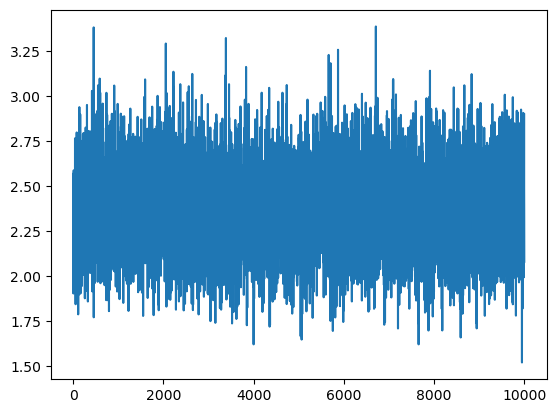

In [163]:
plt.plot(stepi, lossi)

In [164]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3550, grad_fn=<NllLossBackward0>)

In [165]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3754, grad_fn=<NllLossBackward0>)

In [166]:
# when dev loss is nearly equal training loss, -> underfitting -> make model more powerful -> change hidden [6,100] to [6, 300] 
# and this can be confirmed by the plot

In [168]:
# block_size = 3
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape

(torch.Size([182437, 3]),
 torch.Size([182437]),
 torch.Size([22781, 3]),
 torch.Size([22781]))

In [174]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator = g)  # random normal C look up table, embed each char in a 2-dim vector
W1 = torch.randn((2*3, 300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

print("# parameters: ", sum(torch.numel(p) for p in parameters))

# parameters:  10281


In [183]:
# NOW think of forward pass
# generate index for create batch
ix = torch.randint(0, Xtr.shape[0], (32,))  # -> Xtr[ix],  Ytr[ix]  torch.size([32, 3]), torch.size([32,])
# print(C[Xtr[ix]])  # index C by each element in Xtr[ix],  keep shape of Xtr[ix]
embed = C[Xtr[ix]]  # torch.Size([32, 3, 2])
a = embed.view(-1, 6) @ W1 + b1
h = torch.tanh(a)
logits = h @ W2 + b2
print(logits.shape)
loss = F.cross_entropy(logits, Ytr[ix])  
# input logtis vs target: input logits of (minibatch,C) for C classes, (minibatch,C,d1,d2,...,dK) with K≥1 for the K-dimensional cas
# log(Softmax(x)) function to an n-dimensional input Tensor, followed by NLLLoss

torch.Size([32, 27])


# cross_entropy = log(sofmax(input_logits)) + lln (take negative and average over batch)
input = torch.randn(3, 5, requires_grad=True)
target = torch.tensor([1, 0, 4])
print(input)
logsm = F.log_softmax(input, dim=1)
print(logsm)  # log of (0~1) is between (-inf, 0)
output = F.nll_loss(logsm, target) 
# The input given nll_loss forward call is expected to contain log-probabilities of each class, which is exactly the result of log-softmax,
# return  -logsm[of the target class], for batch os size N: sum all examples and take average 
print(output)  

tensor([[ 0.9655,  1.3242, -1.6329, -0.7152,  0.4882],
        [ 0.5920, -1.2657,  1.1230,  0.3179,  0.1609],
        [-0.8043,  0.3087,  1.7718, -0.7476, -1.1029]], requires_grad=True)
tensor([[-1.1977, -0.8390, -3.7961, -2.8784, -1.6750],
        [-1.4508, -3.3086, -0.9199, -1.7249, -1.8819],
        [-2.9439, -1.8309, -0.3678, -2.8871, -3.2425]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(1.8441, grad_fn=<NllLossBackward0>)
# verify 1.8441 = (-(-0.8390) + -(-1.4508) + -(-3.2425))/3

In [192]:
# Xtr.shape, Ytr.shape
BATCH_SIZE = 32

lossi = []
stepi = []


for p in parameters:
  p.requires_grad = True

for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))  # -> Xtr[ix],  Ytr[ix]  torch.size([32, 3]), torch.size([32,])

    embed = C[Xtr[ix]]  # torch.Size([32, 3, 2])
    a = embed.view(-1, 6) @ W1 + b1
    h = torch.tanh(a)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # re-set grad to None or zero
    for p in parameters:
        p.grad = None
    loss.backward()

    if i % 1000 == 0: print(loss)

    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:  # CLASStorch.nn.parameter.Parameter(data=None, requires_grad=True)
        p.data += -lr * p.grad

    # track stats
  
    stepi.append(i)
    lossi.append(loss.log10().item())

    
print(loss)
# tensor(2.0858, grad_fn=<NllLossBackward0>)

tensor(2.2438, grad_fn=<NllLossBackward0>)
tensor(2.4699, grad_fn=<NllLossBackward0>)
tensor(2.6357, grad_fn=<NllLossBackward0>)
tensor(2.1854, grad_fn=<NllLossBackward0>)
tensor(2.5354, grad_fn=<NllLossBackward0>)
tensor(2.7378, grad_fn=<NllLossBackward0>)
tensor(2.1745, grad_fn=<NllLossBackward0>)
tensor(2.7338, grad_fn=<NllLossBackward0>)
tensor(2.7030, grad_fn=<NllLossBackward0>)
tensor(2.6460, grad_fn=<NllLossBackward0>)
tensor(2.3614, grad_fn=<NllLossBackward0>)
tensor(2.6008, grad_fn=<NllLossBackward0>)
tensor(2.6521, grad_fn=<NllLossBackward0>)
tensor(2.4391, grad_fn=<NllLossBackward0>)
tensor(2.6023, grad_fn=<NllLossBackward0>)
tensor(2.5739, grad_fn=<NllLossBackward0>)
tensor(2.6799, grad_fn=<NllLossBackward0>)
tensor(3.0091, grad_fn=<NllLossBackward0>)
tensor(2.5080, grad_fn=<NllLossBackward0>)
tensor(2.6388, grad_fn=<NllLossBackward0>)
tensor(2.3560, grad_fn=<NllLossBackward0>)
tensor(2.6452, grad_fn=<NllLossBackward0>)
tensor(2.5159, grad_fn=<NllLossBackward0>)
tensor(2.70

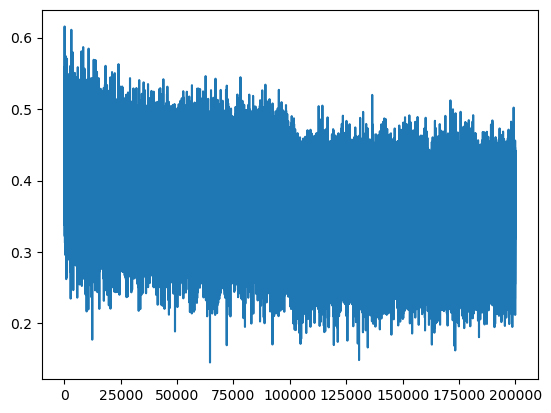

In [193]:
plt.plot(stepi, lossi)

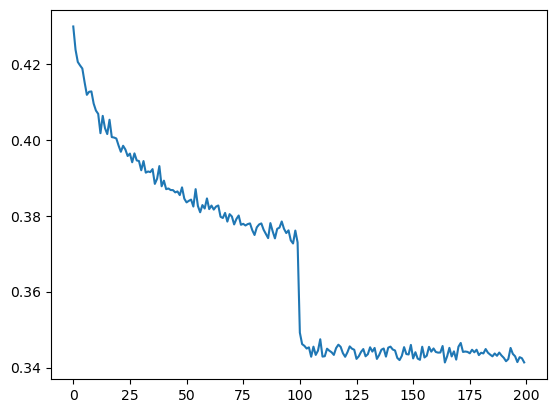

In [198]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [199]:
# dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2430, grad_fn=<NllLossBackward0>)

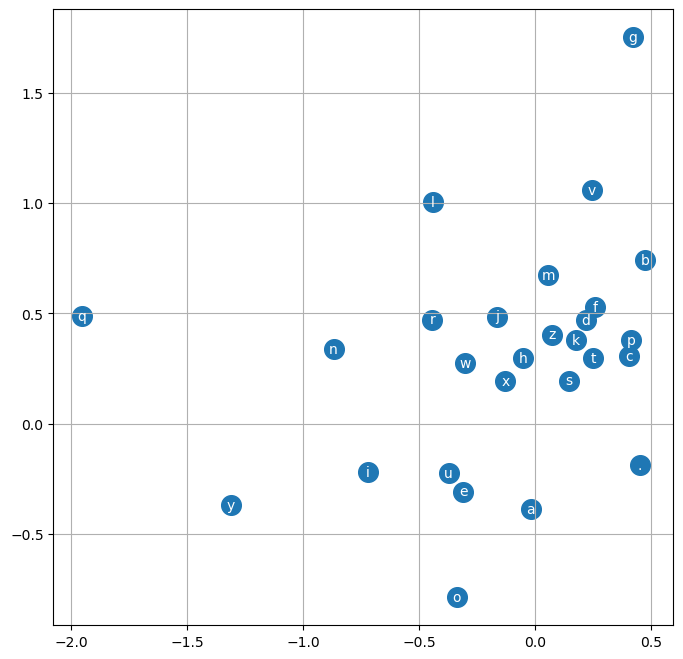

In [200]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [206]:
context = [0] * block_size
print(context)
print(C[torch.tensor([context])])

emb = C[torch.tensor([context])] # (1,block_size,d)
h = torch.tanh(emb.view(1, -1) @ W1 + b1)
logits = h @ W2 + b2
print(logits.shape)

[0, 0, 0]
tensor([[[ 0.4516, -0.1866],
         [ 0.4516, -0.1866],
         [ 0.4516, -0.1866]]], grad_fn=<IndexBackward0>)
torch.Size([1, 27])


In [207]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)



for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
    
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ami.
havi.
kimrix.
thty.
halaysie.
rahnee.
delly.
chiaqui.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quintis.
lilea.
jadil.
wazeroudearynix.
kaen.
dura.
